# Test In Simulation

In [1]:
from Go2Py.robot.fsm import FSM
from Go2Py.robot.remote import KeyboardRemote
from Go2Py.robot.safety import SafetyHypervisor
from Go2Py.sim.mujoco import Go2Sim
from Go2Py.control.walk_these_ways import *

pygame 2.6.1 (SDL 2.28.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [20]:
robot = Go2Sim()

In [21]:
map = np.zeros((1200, 1200))
map[:200, :200] = 255
robot.updateHeightMap(map)

In [22]:
remote = KeyboardRemote()
robot.sitDownReset()
safety_hypervisor = SafetyHypervisor(robot)

In [23]:
class walkTheseWaysController:
    def __init__(self, robot, remote, checkpoint):
        self.remote = remote
        self.robot = robot
        self.cfg = loadParameters(checkpoint)
        self.policy = Policy(checkpoint)
        self.command_profile = CommandInterface()
        self.agent = WalkTheseWaysAgent(self.cfg, self.command_profile, self.robot)
        self.agent = HistoryWrapper(self.agent)
        self.hist_data = {}
        self.init()

    def init(self):
        self.obs = self.agent.reset()
        self.policy_info = {}
        self.command_profile.yaw_vel_cmd = 0.0
        self.command_profile.x_vel_cmd = 0.0
        self.command_profile.y_vel_cmd = 0.0
        self.command_profile.stance_width_cmd=0.25
        self.command_profile.footswing_height_cmd=0.08
        self.command_profile.step_frequency_cmd = 3.0
        self.command_profile.bodyHeight = 0.00

    def update(self, robot, remote):
        action = self.policy(self.obs, self.policy_info)
        self.obs, self.ret, self.done, self.info = self.agent.step(action)
        vy = 0.8 # Update these based on your implementation of the remote controller
        vx = 0.
        omega = 0.8
        self.command_profile.x_vel_cmd = vx*1.5
        self.command_profile.y_vel_cmd = vy*1.5
        self.command_profile.yaw_vel_cmd = omega
        for key, value in self.info.items():
            if key in self.hist_data:
                self.hist_data[key].append(value)
            else:
                self.hist_data[key] = [value]

In [24]:
checkpoint = "../Go2Py/assets/checkpoints/walk_these_ways/"
controller = walkTheseWaysController(robot, remote, checkpoint)
fsm = FSM(robot, remote, safety_hypervisor, user_controller_callback=controller.update)

p_gains: [20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]


controller timeout


In [26]:
import time
contacts = []
feet_vels = []

for i in range(2000):
    contact_state = robot.getFootContact()>15
    sites = ['FR_foot', 'FL_foot', 'RR_foot', 'RL_foot']
    feet_vel = [np.linalg.norm(robot.getFootVelInWorld(s)) for s in sites]
    contacts.append(contact_state)
    feet_vels.append(feet_vel)
    time.sleep(0.01)

feet_vels = np.stack(feet_vels)
contacts = np.stack(contacts)

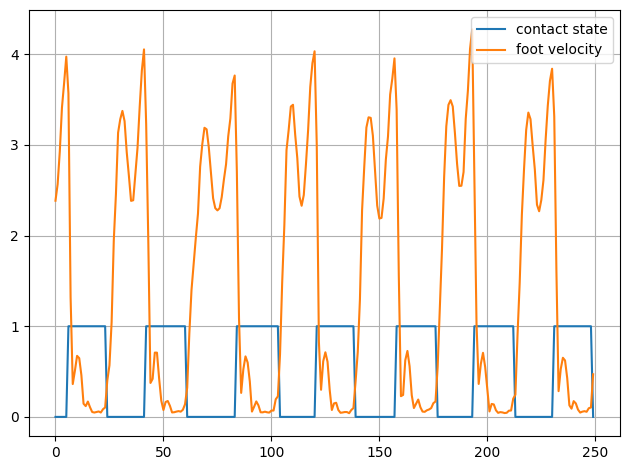

In [17]:
import matplotlib.pyplot as plt
start = 250
end = 500
plt.plot(contacts[start:end,0])
plt.plot(feet_vels[start:end,0])
plt.legend(['contact state', 'foot velocity'])
plt.grid(True)
plt.tight_layout()
plt.savefig('walk.png')

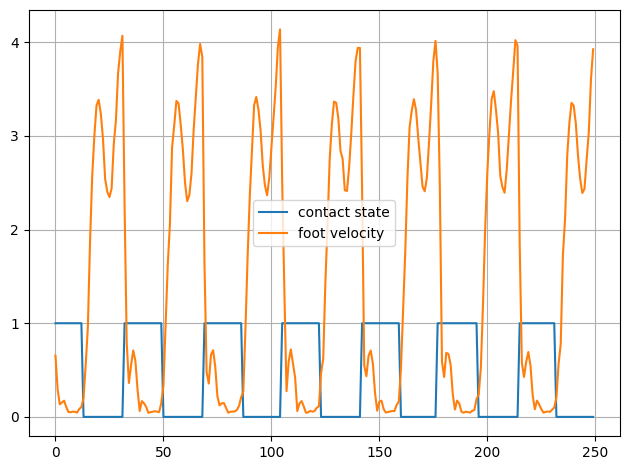

In [27]:
import matplotlib.pyplot as plt
start = 250
end = 500
plt.plot(contacts[start:end,0])
plt.plot(feet_vels[start:end,0])
plt.legend(['contact state', 'foot velocity'])
plt.grid(True)
plt.tight_layout()
plt.savefig('walk_these_ways_random_adaptation.png')

In [ ]:
controller.policy.adaptation_module

In [7]:
controller.command_profile.pitch_cmd=0.0
controller.command_profile.body_height_cmd=0.0
controller.command_profile.footswing_height_cmd=0.08
controller.command_profile.roll_cmd=0.0
controller.command_profile.stance_width_cmd=0.2
controller.command_profile.x_vel_cmd=-0.2
controller.command_profile.y_vel_cmd=0.01
controller.command_profile.setGaitType("trotting")

Pressing `u` on the keyboard will make the robot stand up. This is equivalent to the `L2+A` combo of the Go2 builtin state machine. After the the robot is on its feet, pressing `s` will hand over the control the RL policy. This action is equivalent to the `start` key of the builtin controller. When you want to stop, pressing `u` again will act similarly to the real robot and locks it in standing mode. Finally, pressing `u` again will command the robot to sit down.

In [18]:
fsm.close()
robot.close()

In [ ]:
import matplotlib.pyplot as plt
# Assuming 'controller.hist_data["foot_contact_forces_mag"]' is a dictionary with foot contact force magnitudes
foot_contact_forces_mag = np.array(controller.hist_data["foot_contact_forces_mag"])

# Number of feet (foot_nb)
foot_nb = foot_contact_forces_mag.shape[1]

# Number of rows needed for the grid, with 3 columns per row
n_cols = 3
n_rows = int(np.ceil(foot_nb / n_cols))

# Create the figure and axes for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array for easy indexing (in case of multiple rows)
axes = axes.flatten()

# Plot each foot's contact force magnitude
for i in range(foot_nb):
    axes[i].plot(foot_contact_forces_mag[:, i])
    axes[i].set_title(f'Foot {i+1} Contact Force Magnitude')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Force Magnitude')

# Remove any empty subplots if foot_nb is not a multiple of 3
for j in range(foot_nb, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.savefig("foot_contact_profile.png")
plt.show()

# Test on Real Robot

In [ ]:
from Go2Py.robot.fsm import FSM
from Go2Py.robot.remote import UnitreeRemote
from Go2Py.robot.safety import SafetyHypervisor
from Go2Py.control.walk_these_ways import *

In [2]:
from Go2Py.robot.interface import GO2Real
import numpy as np
robot = GO2Real(mode='lowlevel')

In [3]:
remote = UnitreeRemote(robot)
safety_hypervisor = SafetyHypervisor(robot)

In [4]:
class walkTheseWaysController:
    def __init__(self, robot, remote, checkpoint):
        self.remote = remote
        self.robot = robot
        self.cfg = loadParameters(checkpoint)
        self.policy = Policy(checkpoint)
        self.command_profile = CommandInterface()
        self.agent = WalkTheseWaysAgent(self.cfg, self.command_profile, self.robot)
        self.agent = HistoryWrapper(self.agent)
        self.init()

    def init(self):
        self.obs = self.agent.reset()
        self.policy_info = {}
        self.command_profile.yaw_vel_cmd = 0.0
        self.command_profile.x_vel_cmd = 0.0
        self.command_profile.y_vel_cmd = 0.0
        self.command_profile.stance_width_cmd=0.25
        self.command_profile.footswing_height_cmd=0.08
        self.command_profile.step_frequency_cmd = 3.0
        self.command_profile.bodyHeight = 0.00

    def update(self, robot, remote):
        action = self.policy(self.obs, self.policy_info)
        self.obs, self.ret, self.done, self.info = self.agent.step(action)
        vy = -robot.getRemoteState().lx
        vx = robot.getRemoteState().ly
        omega = -robot.getRemoteState().rx*2.2
        self.command_profile.x_vel_cmd = vx*1.5
        self.command_profile.y_vel_cmd = vy*1.5
        self.command_profile.yaw_vel_cmd = omega

In [ ]:
checkpoint = "../Go2Py/assets/checkpoints/walk_these_ways/"
controller = walkTheseWaysController(robot, remote, checkpoint)
safety_hypervisor = SafetyHypervisor(robot)

In [6]:
controller.command_profile.pitch_cmd=0.0
controller.command_profile.body_height_cmd=0.0
controller.command_profile.footswing_height_cmd=0.04
controller.command_profile.roll_cmd=0.0
controller.command_profile.stance_width_cmd=0.2
controller.command_profile.x_vel_cmd=-0.2
controller.command_profile.y_vel_cmd=0.01
controller.command_profile.setGaitType("trotting")

In [ ]:
fsm = FSM(robot, remote, safety_hypervisor, user_controller_callback=controller.update)

Pressing `L2+A` to command the robot to stand up. After the the robot is on its feet, pressing `start` will hand over the control the RL policy. When you want to stop, pressing `L2+A` again will act similarly to the factory controller and locks the robot in standing mode. Finally, pressing `L2+A` again will command the robot to sit down.

In [ ]:
fsm.close()